In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
import os

In [37]:
metadata = pd.read_csv("/home/saji/DSprojects/CloneVoiceDetection/data/LA_CM_trial_metadata.txt",sep=" ",header=None)
audio_path = "/home/saji/DSprojects/CloneVoiceDetection/data/ASVspoof2021_LA_eval/flac/"

In [38]:
metadata.head()

,0,1,2,3,4,5,6,7
0,LA_0009,LA_E_9332881,alaw,ita_tx,A07,spoof,notrim,eval
1,LA_0009,LA_E_6866159,alaw,ita_tx,A07,spoof,notrim,eval
2,LA_0009,LA_E_5464494,alaw,sin_tx,A07,spoof,notrim,eval
3,LA_0009,LA_E_4759417,alaw,sin_tx,A07,spoof,notrim,eval
4,LA_0009,LA_E_2667748,alaw,loc_tx,A07,spoof,notrim,eval


In [39]:
metadata.describe()

,0,1,2,3,4,5,6,7
count,181566,181566,181566,181566,181566,181566,181566,181566
unique,67,181566,7,5,14,2,2,3
top,LA_0018,LA_E_9332881,alaw,loc_tx,bonafide,spoof,notrim,eval
freq,7294,1,25938,75110,18452,163114,164640,148176


In [40]:
print(metadata[2].unique())
print(metadata[3].unique())
print(metadata[4].unique())
print(metadata[5].unique())
print(metadata[6].unique())
print(metadata[7].unique())

['alaw' 'ulaw' 'gsm' 'pstn' 'g722' 'opus' 'none']
['ita_tx' 'sin_tx' 'loc_tx' 'mad_tx' '-']
['A07' 'A08' 'A09' 'A10' 'A11' 'A12' 'A13' 'A14' 'A15' 'A16' 'A17' 'A18'
 'A19' 'bonafide']
['spoof' 'bonafide']
['notrim' 'only_speech']
['eval' 'progress' 'hidden']


In [41]:
metadata.columns = ["speaker_ID","audio_ID","codec","transmission_geo", "spoof_type", "target", "trim_status", "subset"]

In [42]:
#Assigning Gender from kaggle data 2019 dataset
male = {'LA_0071','LA_0073','LA_0070','LA_0076','LA_0007','LA_0003','LA_0015','LA_0005','LA_0048','LA_0038','LA_0032','LA_0046','LA_0018','LA_0013','LA_0036','LA_0023','LA_0030','LA_0002','LA_0040','LA_0028','LA_0011','LA_0001','LA_0044','LA_0021','LA_0025'}
female = {'LA_0078','LA_0075','LA_0074','LA_0072','LA_0077','LA_0069','LA_0026','LA_0041','LA_0043','LA_0012','LA_0031','LA_0037','LA_0008','LA_0029','LA_0004','LA_0045','LA_0010','LA_0034','LA_0033','LA_0042','LA_0035','LA_0027','LA_0014','LA_0024','LA_0016','LA_0017','LA_0019','LA_0006','LA_0039','LA_0009','LA_0047','LA_0022','LA_0020'}
# new column 'gender'
metadata['gender'] = metadata['speaker_ID'].apply(lambda x: 'male' if x in male else ('female' if x in female else 'unknown'))


In [43]:
metadata.head()

,speaker_ID,audio_ID,codec,transmission_geo,spoof_type,target,trim_status,subset,gender
0,LA_0009,LA_E_9332881,alaw,ita_tx,A07,spoof,notrim,eval,female
1,LA_0009,LA_E_6866159,alaw,ita_tx,A07,spoof,notrim,eval,female
2,LA_0009,LA_E_5464494,alaw,sin_tx,A07,spoof,notrim,eval,female
3,LA_0009,LA_E_4759417,alaw,sin_tx,A07,spoof,notrim,eval,female
4,LA_0009,LA_E_2667748,alaw,loc_tx,A07,spoof,notrim,eval,female


In [64]:
metadata.to_csv('/home/saji/DSprojects/CloneVoiceDetection/data/ASVspoof2021_LA_eval/metadata.csv')

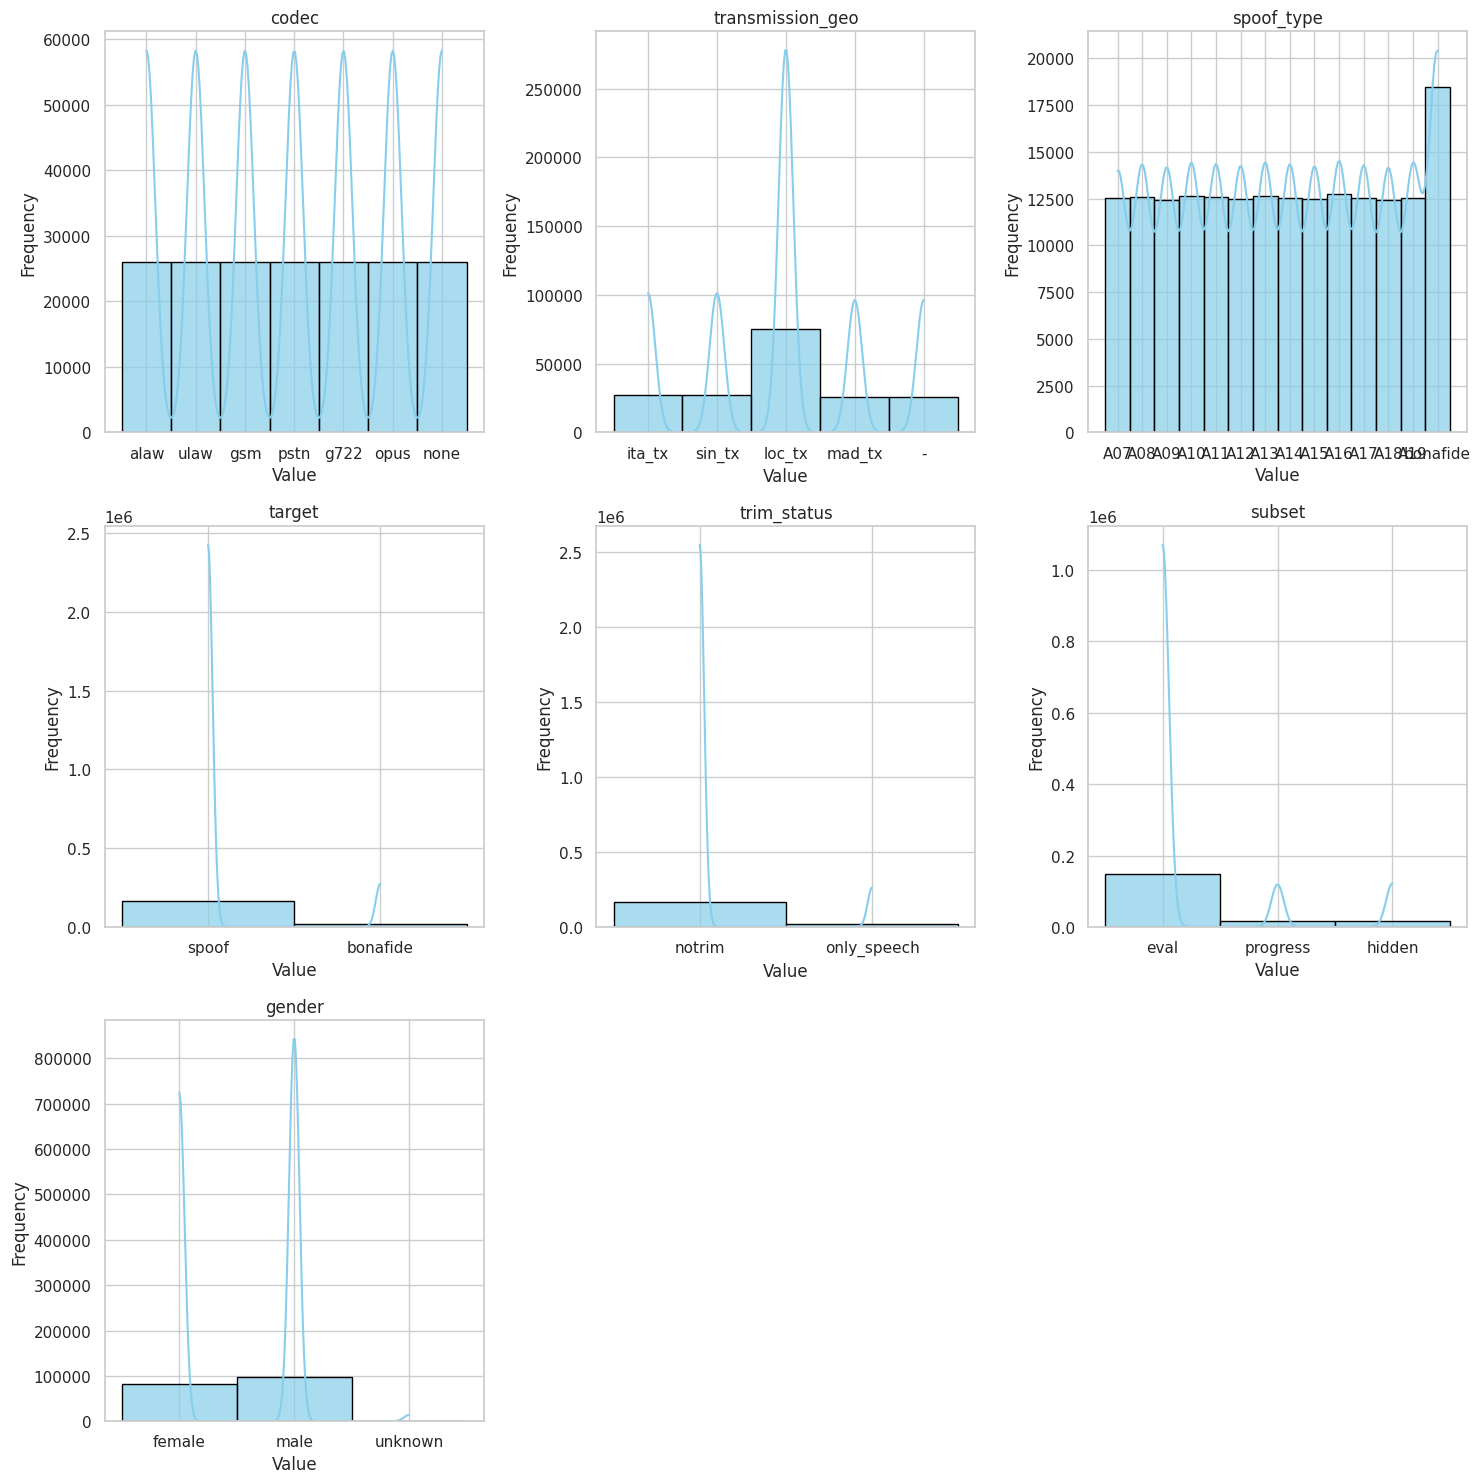

In [44]:

sns.set(style="whitegrid")
sns.light_palette("seagreen", as_cmap=True)

features = metadata.columns[2:]
num_features = len(features)
num_cols = 3  
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    sns.histplot(data=metadata, x=feature, kde=True, ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Remove empty subplots
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

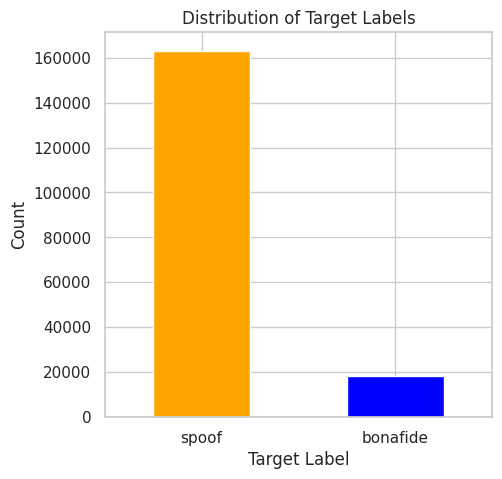

In [45]:
target_distribution = metadata['target'].value_counts()

plt.figure(figsize=(5, 5))
target_distribution.plot(kind='bar',color=['orange','blue'])
plt.title('Distribution of Target Labels')
plt.xlabel('Target Label')
plt.ylabel('Count')
plt.xticks(rotation=0) #rotates labels
plt.show()


<Figure size 1000x600 with 0 Axes>

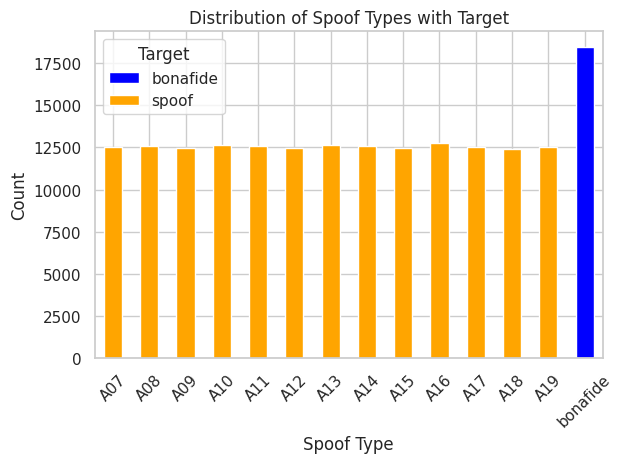

In [46]:
cross_tab = pd.crosstab(metadata['spoof_type'], metadata['target'])

plt.figure(figsize=(10, 6))
cross_tab.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title('Distribution of Spoof Types with Target')
plt.xlabel('Spoof Type')
plt.ylabel('Count')
plt.legend(title='Target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


A07


A08


A09


A10


A11


A12


A13


A14


A15


A16


A17


A18


A19


bonafide


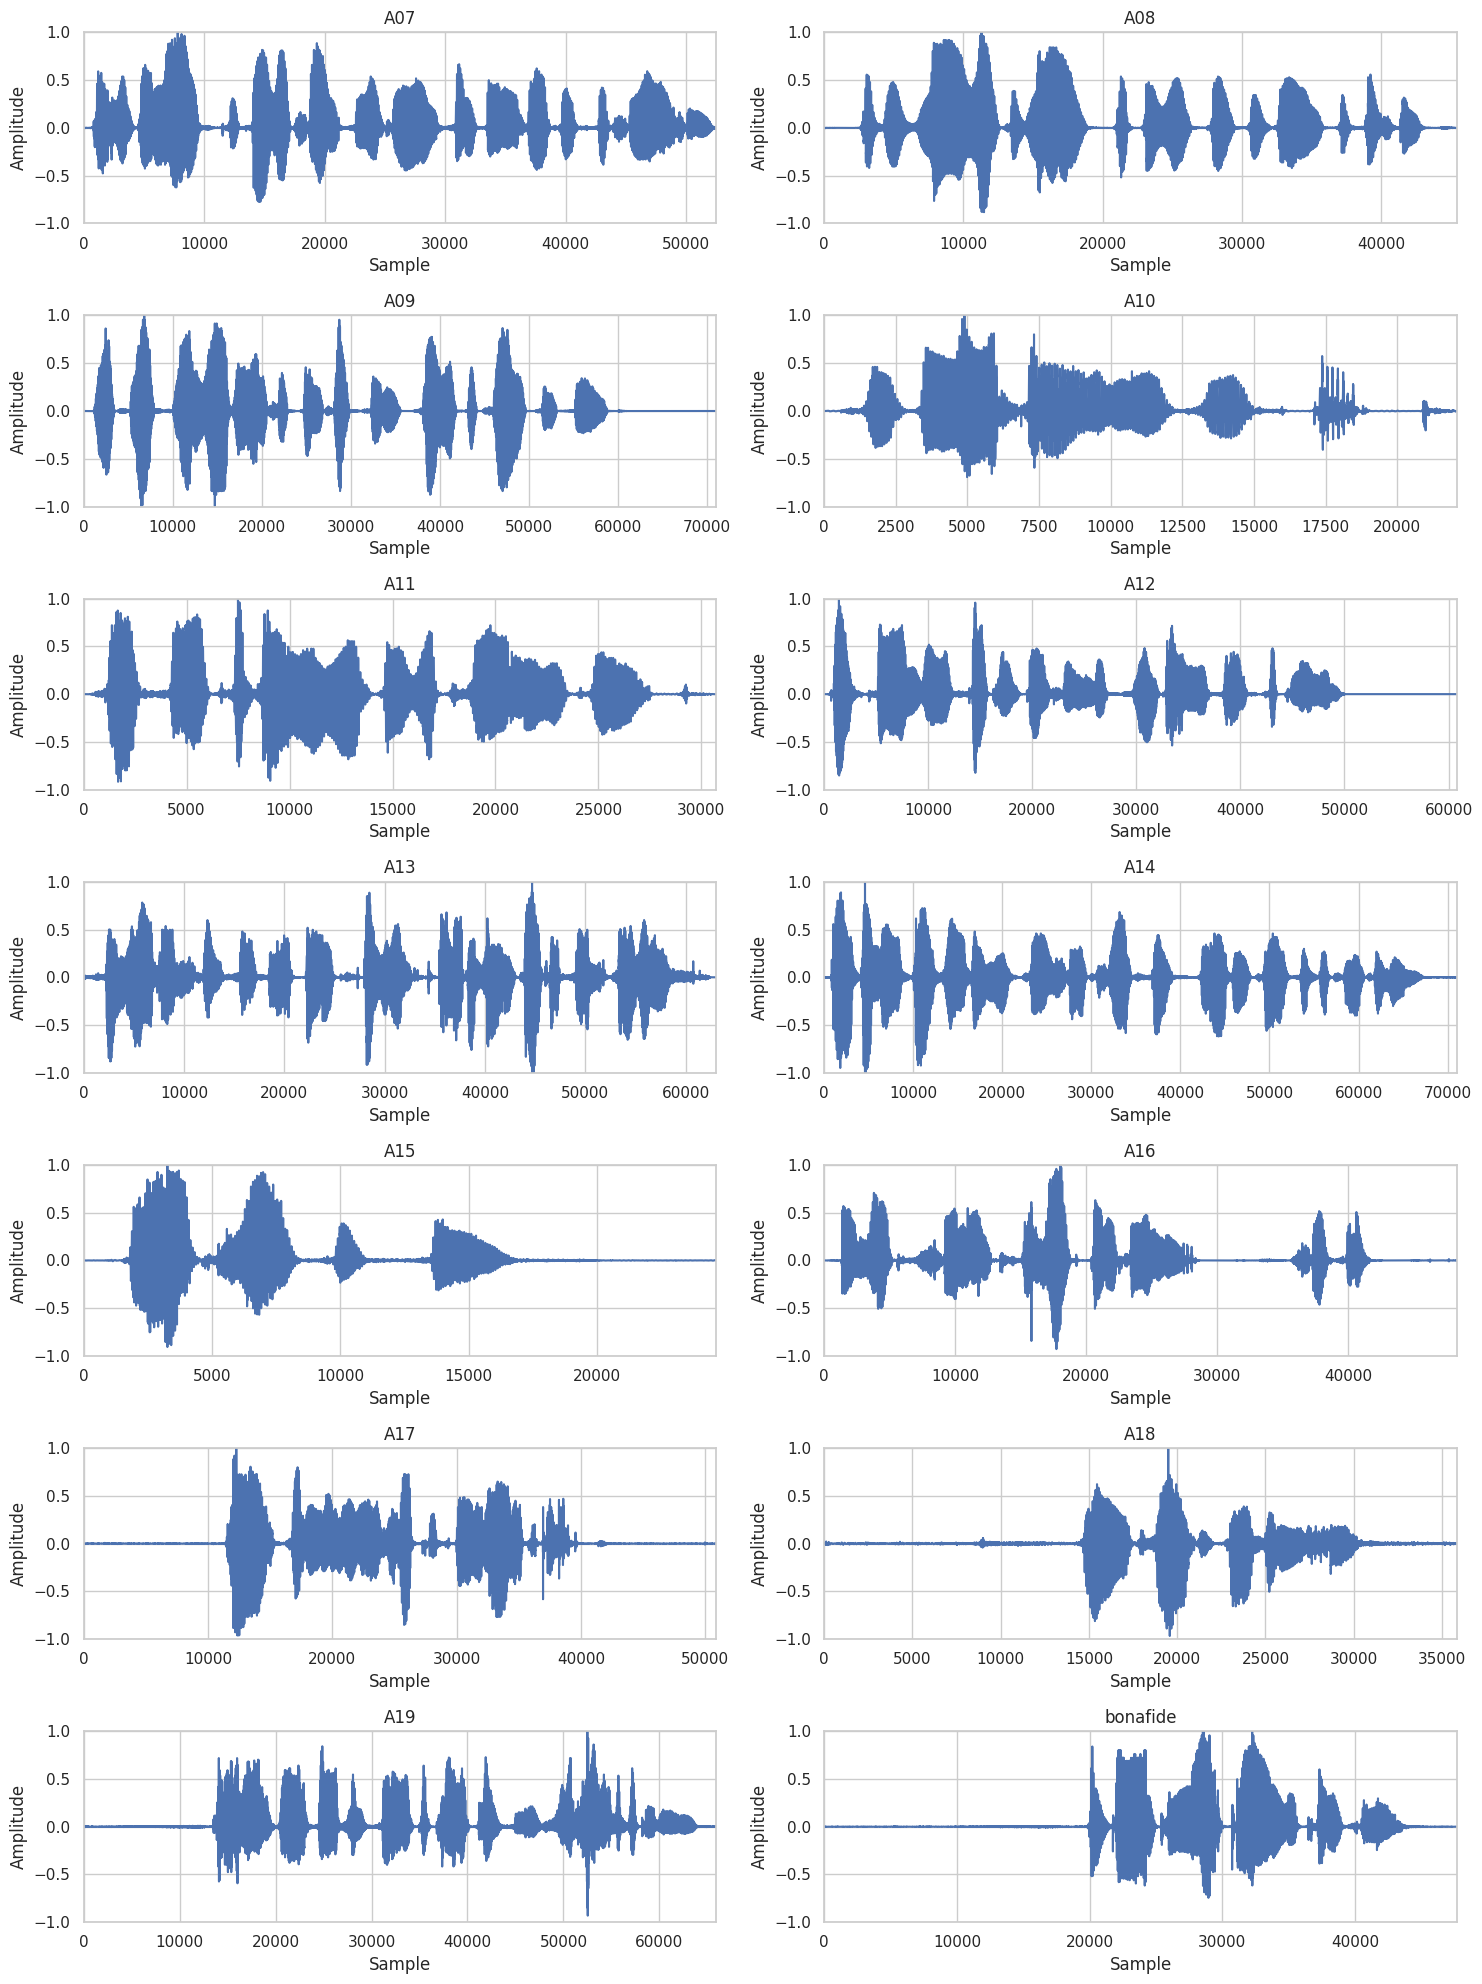

In [55]:
spoof_types = metadata['spoof_type'].unique()

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20))
axes = axes.ravel()

for idx, spoof in enumerate(spoof_types):
    filename = metadata[metadata['spoof_type'] == spoof]['audio_ID'].iloc[0]

    file_path = audio_path + filename + '.flac'
    audio, sr = librosa.load(file_path, sr=None)

    axes[idx].plot(audio)
    axes[idx].set_title(spoof)
    axes[idx].set_xlabel('Sample')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_xlim([0, len(audio)])
    axes[idx].set_ylim([-1, 1])

    display(Audio(audio, rate=sr))
    print(spoof)

plt.tight_layout()
plt.show()


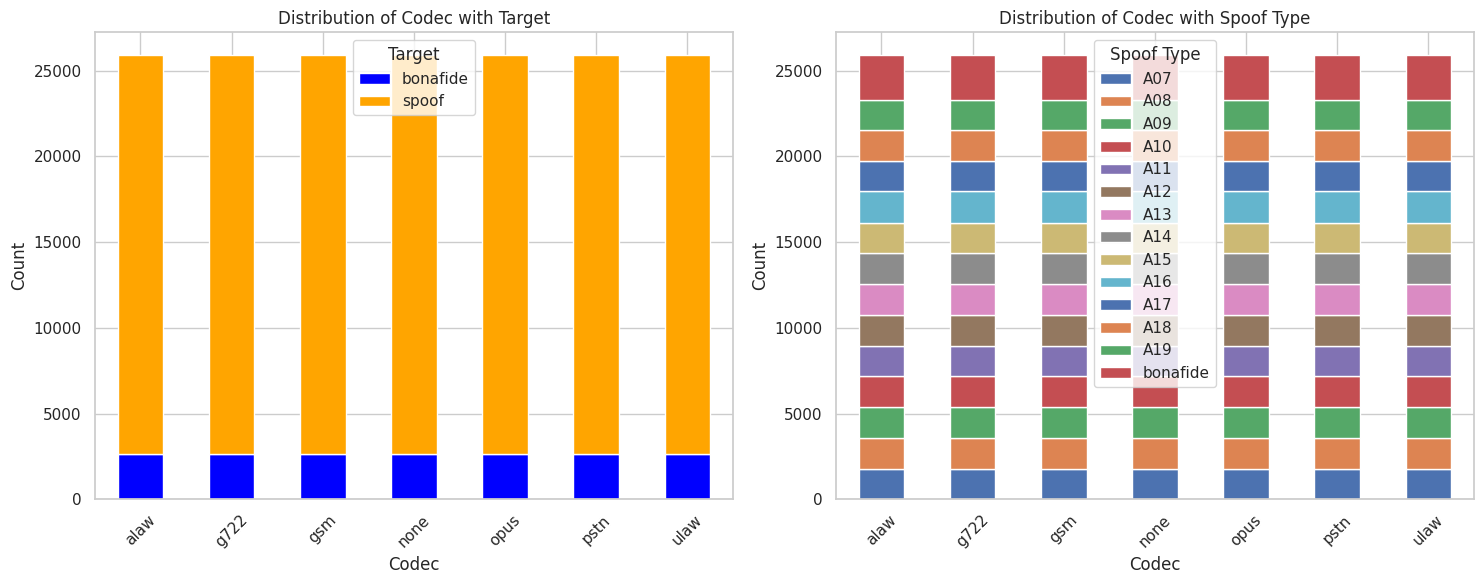

In [49]:
plt.figure(figsize=(15, 6))

#Distribution of codec with target
plt.subplot(1, 2, 1)
codec_target_cross_tab = pd.crosstab(metadata['codec'], metadata['target'])
codec_target_cross_tab.plot(kind='bar', stacked=True, ax=plt.gca(), color=['blue', 'orange'])
plt.title('Distribution of Codec with Target')
plt.xlabel('Codec')
plt.ylabel('Count')
plt.legend(title='Target')
plt.xticks(rotation=45)

#distribution of codec with spoof type
plt.subplot(1, 2, 2)
codec_spoof_cross_tab = pd.crosstab(metadata['codec'], metadata['spoof_type'])
codec_spoof_cross_tab.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of Codec with Spoof Type')
plt.xlabel('Codec')
plt.ylabel('Count')
plt.legend(title='Spoof Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


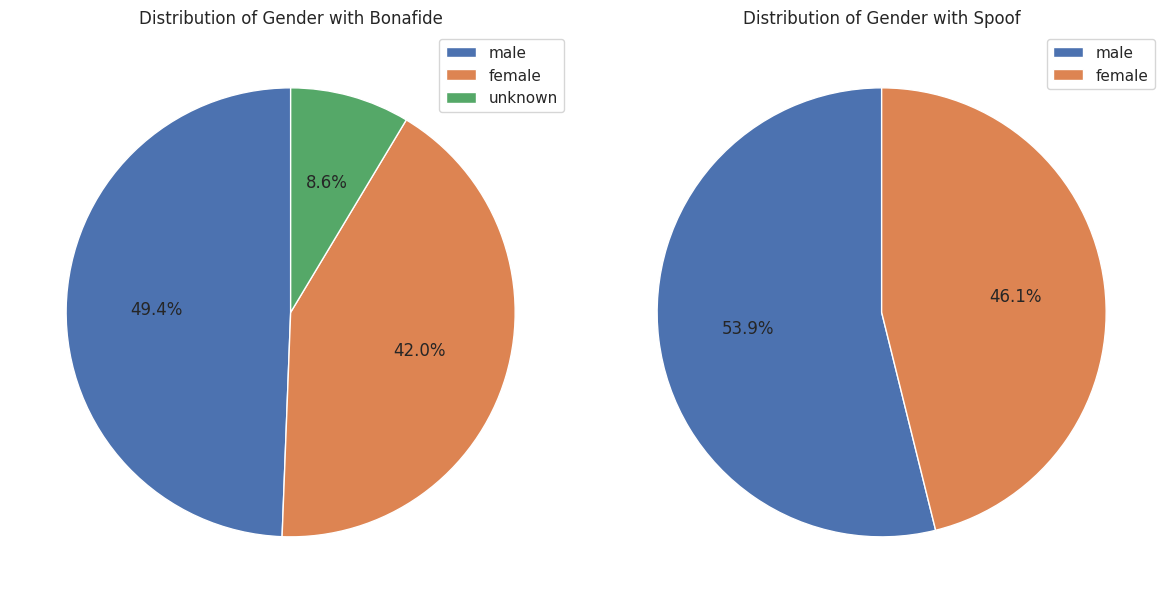

In [57]:

#distribution of gender with target labels
plt.figure(figsize=(12, 6))

# Pie chart for 'bonafide' target label
plt.subplot(1, 2, 1)
bonafide_gender_cross_tab = metadata[metadata['target'] == 'bonafide']['gender'].value_counts()
bonafide_gender_cross_tab.plot(kind='pie', autopct='%1.1f%%', labels=None, startangle=90)
plt.title('Distribution of Gender with Bonafide')
plt.ylabel('')
plt.legend(bonafide_gender_cross_tab.index, loc='best')

# Pie chart for 'spoof' target label
plt.subplot(1, 2, 2)
spoof_gender_cross_tab = metadata[metadata['target'] == 'spoof']['gender'].value_counts()
spoof_gender_cross_tab.plot(kind='pie', autopct='%1.1f%%', labels=None, startangle=90)
plt.title('Distribution of Gender with Spoof')
plt.ylabel('')  # Remove y-axis label
plt.legend(spoof_gender_cross_tab.index, loc='best')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

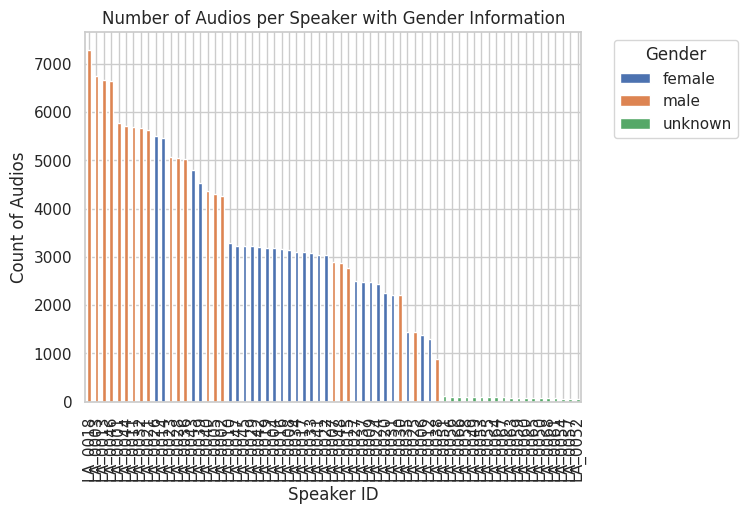

In [63]:
speaker_counts = metadata.groupby(['speaker_ID', 'gender']).size().unstack(fill_value=0)

speaker_counts['Total'] = speaker_counts.sum(axis=1)
speaker_counts.sort_values(by='Total', ascending=False, inplace=True)
speaker_counts.drop(columns='Total', inplace=True)

plt.figure(figsize=(10, 6))
speaker_counts.plot(kind='bar', stacked=True)
plt.title('Number of Audios per Speaker with Gender Information')
plt.xlabel('Speaker ID')
plt.ylabel('Count of Audios')
plt.xticks(rotation=90)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
